# Read before doing anything
We found an error in the training dataset 2 (there was a whitespace in front of each feature name). Therefore we preprocessed and fixed it. Our files have been renamed and they are as follows:
* ./data/trn_set_1.csv --> BATADAL_dataset03.csv
* ./data/trn_set_2.csv --> BATADAL_dataset04.csv
* ./data/test_set.csv --> BATADAL_test_dataset.csv

# Discretization Task

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Read the datasets. As a preprocessing step, we drop the discrete variables (the statuses).

In [2]:
file_name = "trn_set_1"
file_name2 = "trn_set_2"

DATA_PATH = r"C:../data/{}.csv".format(file_name)
DATA_PATH2 = r"C:../data/{}.csv".format(file_name2)

data_train1 = pd.read_csv(DATA_PATH, parse_dates=['DATETIME'], index_col = ['DATETIME'], dayfirst=True)
data_train2 = pd.read_csv(DATA_PATH2, parse_dates=['DATETIME'], index_col = ['DATETIME'], dayfirst=True)


#Drop the discrete columns
data_train1.drop(columns = ['S_PU1', 'S_PU2', 'S_PU3', 'S_PU4', 'S_PU5', 'S_PU6', 'S_PU7', 'S_PU8', 'S_PU9', 'S_PU10', 'S_PU11', 'S_V2'], inplace=True)
data_train2.drop(columns = ['S_PU1', 'S_PU2', 'S_PU3', 'S_PU4', 'S_PU5', 'S_PU6', 'S_PU7', 'S_PU8', 'S_PU9', 'S_PU10', 'S_PU11', 'S_V2'], inplace=True)

Let's now choose the signal we want to proceed with in this task and discretize.

The documentation of the competition highlights the importance of an ideal detection mechanism being able to identify which physical components of the network are being attacked. Considering this motivation, we decided to choose as three of the analyzed sensors for the ARMA model the water level in all towers ('L_T1' to 'L_T5'). Additionally, we also analyzed three flow signals, namely 'F_PU1', 'F_PU2' and 'F_PU10'.

In [3]:
signal_names = ['L_T1', 'L_T2', 'L_T3', 'F_PU1', 'L_T4', 'F_PU10']

Let's define a function for discretizing the signal series. The discretization method that we applied was percentiles, as we want to account for different variability across different intervals in the signals.

In [4]:
def discretize_signal(signal, n_bins):
    return pd.qcut(signal, n_bins, labels = False)

Let's define a function for plotting a signal after discretizing it based on a given window and number of bins.

In [5]:
def plot_discrete(signal,window, n_bins):
    signal_continuous = signal[:window]
    signal_discretized = discretize_signal(signal_continuous, n_bins)
    
    plt.figure(figsize=(17, 3))
    plt.plot(signal_continuous)
    plt.title("Original signal")
    plt.show()
    
    plt.figure(figsize=(17, 3))
    plt.step(signal_discretized.index, signal_discretized)
    plt.title("Discretized signal")
    plt.show()

Now we will plot the discretization of the chosen signals using 4 bins and a week as window for plotting.



 Plotting original and discretized signal for: L_T1


C:\Users\biby_\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


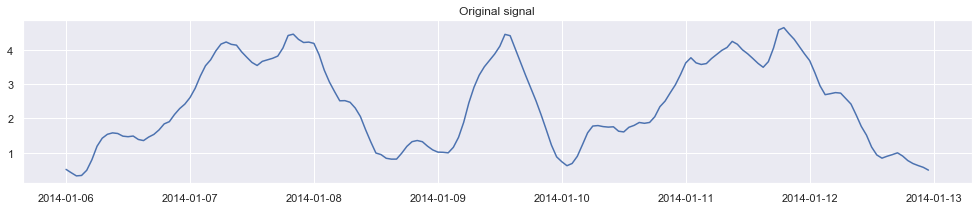

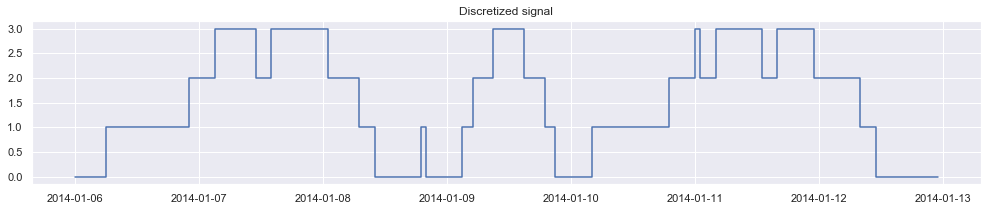



 Plotting original and discretized signal for: L_T2


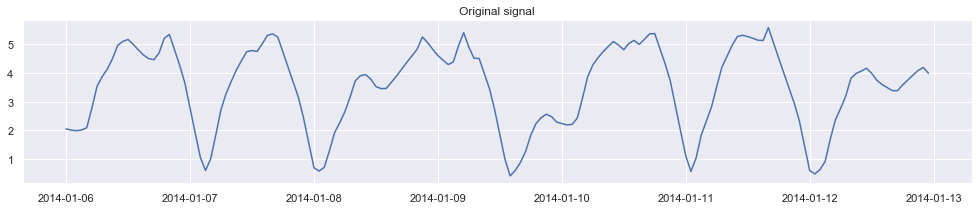

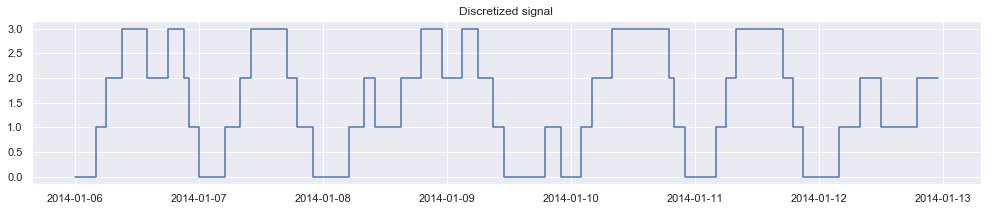



 Plotting original and discretized signal for: L_T3


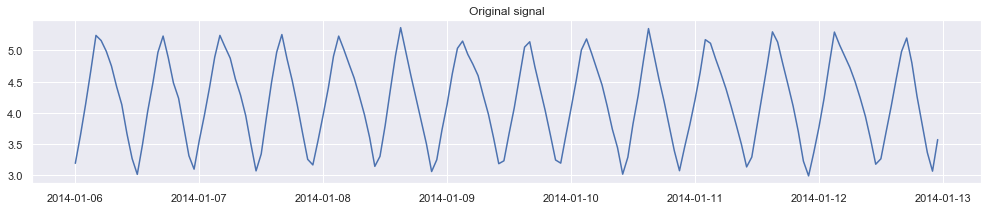

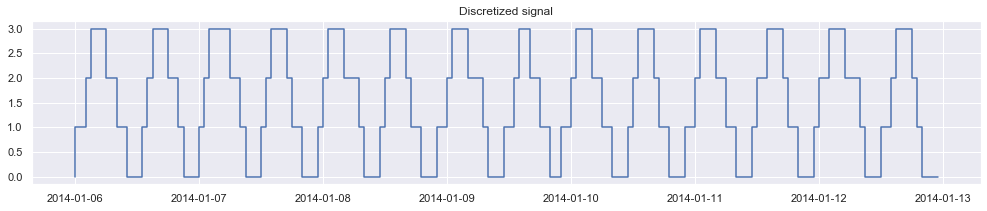



 Plotting original and discretized signal for: F_PU1


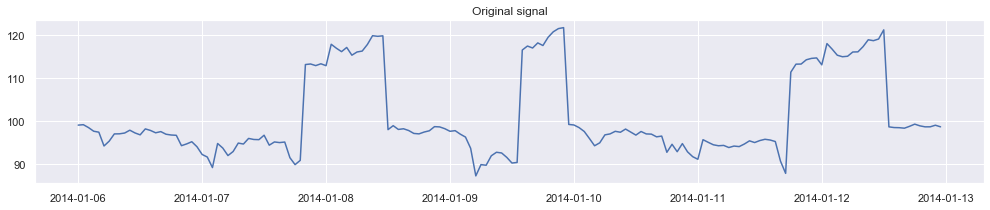

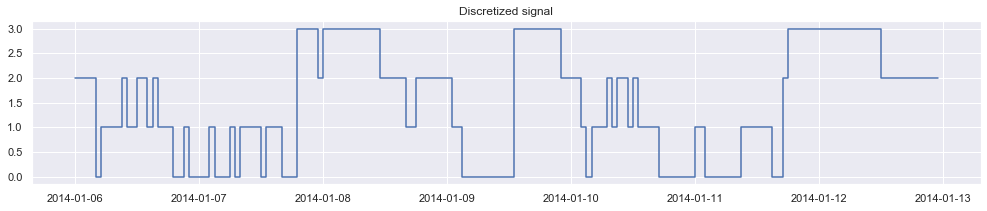



 Plotting original and discretized signal for: L_T4


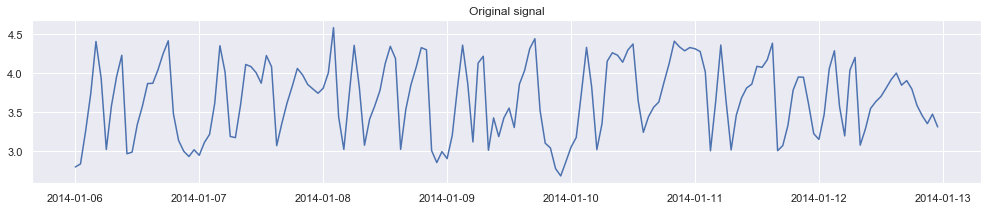

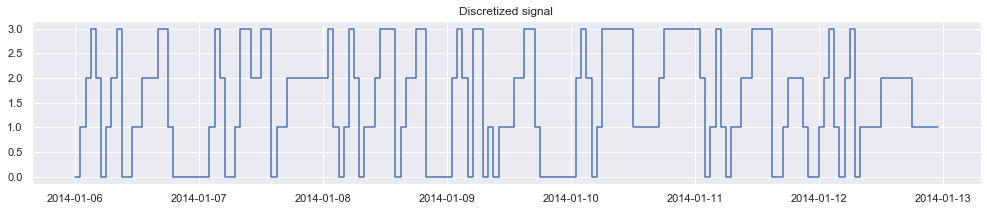



 Plotting original and discretized signal for: F_PU10


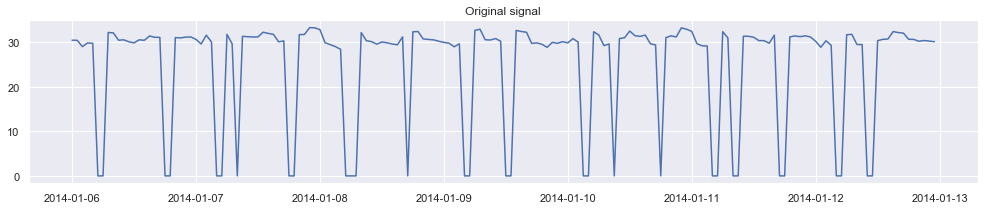

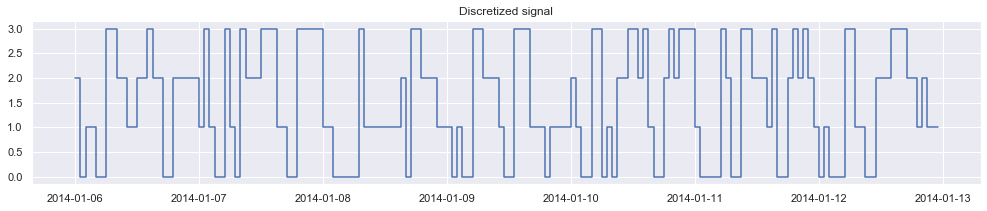

In [6]:
n_bins = 4
n_hours = 24*7

for signal in signal_names:
    print(f'\n\n Plotting original and discretized signal for: {signal}')
    plot_discrete(data_train1[signal], n_hours, n_bins)

# N-Grams

Let's work on n-grams now. 
First, we define a function for generating all the n-grams given the discretized signal, where n is defined by the user.

In [7]:
def get_ngrams(discrete_signal, n):
    return zip(*[discrete_signal[index:] for index in range(n)])

Let's define a function for computing the probabilities for the generated n-grams based on the given discretized signal. n is defined by the user. We apply Laplace smoothing for the probabilities.

In [8]:
def ngram_probabilities(discrete_signal, n):
    
    #Define a dicitonary for counting each n-gram
    ngrams_count = {}
    
    #Let's generate the n-grams and 
    ngrams = get_ngrams(discrete_signal, n)
    
    for ngram in ngrams:
        if ngram in ngrams_count.keys():
            ngrams_count[ngram] += 1
        else:
            ngrams_count[ngram] = 1
            
    #Compute the total number of ngrams for computing probabilities
    total_ngrams = sum(ngrams_count.values())

    #Compute the total number of ngrams we could have for performing Laplace smoothing
    total_possible_ngrams = discrete_signal.nunique()**n
    
    #Compute the smoothed probability for each n-gram
    for key in ngrams_count.keys():
        ngrams_count[key] = (ngrams_count[key] + 1)/(total_ngrams + total_possible_ngrams)
        
    #Save the probability for other n-grams that we did not encounter during training
    ngrams_count['other'] = 1/(total_ngrams + total_possible_ngrams)
        
    return ngrams_count   
    

We decided to apply n-grams for detecting anomalies. The n-grams and their associated probabilities were computed based on the training set 1, containing no anomalous data. The way in which the anomalies were detected, based on the data in training set 2, is by defining a larger window and sliding it over the signal. In each window, we computing the n-grams multiplying their probabilities. For each data point in the signal, we keep the smallest probability found while sliding the windows. Finally, all the data points that had the associated probability lower than a threshold are marked as attack. 

In order to find the appropriate number of bins for discretizing the signals, the value of n for the n-grams, the sliding window for anomaly detection and the threshold, Grid Search is next employed based on the F0.25 score.

# Grid Search

We define a function for computing the confusion matrix in order to later compute the F0.25 score used for optimizing the parameters with Grid Search.

In [9]:
def get_conf_mat_entry(results, true_attack, pred_attack):
    # just a helper function
    result = results[
        (results['true'] == (1 if true_attack else 0)) 
        & 
        (results['pred'] == (1 if pred_attack else 0))
    ]
    #print(result.shape[0])
    return result.shape[0]

We implement Grid Search based on the F0.25 score in order to determine the best parameter values for each signal that we consider for this task. The parameters that we optimize for are the following: number of bins, n for the n-grams computation, threshold for anomaly detection and window.

In [29]:
def grid_search_for_signal(signal, signal2):
    n_bins = [3,4]
    n = [3,4,5,6]
    window_detection = [7,10,15,20,24]
    threshold = [1.1, 1.5, 1.75, 2,3,5,7,10,15, 25, 50, 75, 100, 150, 300, 500] #this is by how much we increase the min probability

    
    beta = 0.25 #for computing the F0.25 score as a metric for Grid Search
    f_beta_best = 0
    n_bins_best = 0
    n_best = 0
    threshold_best = 0
    window_best = 0
    precision_best = 0
    recall_best = 0
    tp_best = 0
    tn_best = 0
    fp_best = 0
    fn_best = 0

    for current_n_bins in n_bins:
        #discretize the signal
        discrete_signal = discretize_signal(signal, current_n_bins)
        discrete_signal2 = discretize_signal(signal2, current_n_bins)

        for current_n in n:
            #get the ngrams probabilities for this training data
            ngrams_prob = ngram_probabilities(discrete_signal, current_n)

            for current_window in window_detection:  

                detection_series = pd.DataFrame(np.ones(discrete_signal2.size), discrete_signal2.index)

                for num_idx, index in enumerate(discrete_signal2.index[:-current_window+1]):
                    subset_series = discrete_signal2.iloc[num_idx:(num_idx+current_window)]

                    subset_ngrams = get_ngrams(subset_series, current_n)
                    prob_product = 1
                    for ngram in subset_ngrams:
                        if ngram in ngrams_prob.keys():
                            prob_product *= ngrams_prob[ngram]
                        else:
                            prob_product *= ngrams_prob['other']

                    for num_idx_det, index_det in enumerate(detection_series.index[num_idx:(num_idx+current_window)]):
                        if detection_series.loc[index_det].item() > prob_product:
                            detection_series.loc[index_det] = prob_product

                #Loop over threshold values
                for current_threshold in threshold:
                    min_prob = np.min(detection_series).item()

                    final_detection = pd.DataFrame(np.zeros(discrete_signal2.size), discrete_signal2.index)

                    thresh = current_threshold * min_prob

                    for num_idx_det, index_det in enumerate(detection_series.index):
                        if detection_series.loc[index_det].item() < thresh:
                            final_detection.loc[index_det] = 1


                    #print(f"Number of bins {current_n_bins}, n-grams {current_n}, window size {current_window}, threshold {current_threshold}")

                    #Compute F0.25 score

                    res = pd.concat([data_train2['ATT_FLAG'].map({-999:0, 1:1}), final_detection], axis=1)
                    res.columns = ['true', 'pred']
                    res.set_index(final_detection.index)

                    t_p = get_conf_mat_entry(res, true_attack=True, pred_attack=True)
                    t_n = get_conf_mat_entry(res, true_attack=False, pred_attack=False)
                    f_p = get_conf_mat_entry(res, true_attack=False, pred_attack=True)
                    f_n = get_conf_mat_entry(res, true_attack=True, pred_attack=False)

                    precision = t_p/(t_p + f_p)
                    recall = t_p/(t_p + f_n)                

                    if (precision + recall ) == 0:
                        continue

                    f_beta = ((1+ beta**2)*precision*recall)/(beta**2 * precision + recall)
                    
                    if f_beta > f_beta_best:                              
                        f_best = f_beta
                        n_bins_best = current_n_bins
                        n_best = current_n
                        window_best = current_window
                        threshold_best = current_threshold
                        precision_best = precision
                        recall_best = recall
                        tp_best = t_p
                        tn_best = t_n
                        fp_best = f_p
                        fn_best = f_n

 
                              

    
    #REBUILD THE RESULT WITH THE BEST PARAMETERS AND PLOT IT
                              
    #discretize the signals
    discrete_signal = discretize_signal(signal, n_bins_best)
    discrete_signal2 = discretize_signal(signal2, n_bins_best)

    #get the ngrams probabilities for this training data
    ngrams_prob = ngram_probabilities(discrete_signal, n_best)

    detection_series = pd.DataFrame(np.ones(discrete_signal2.size), discrete_signal2.index)

    #apply the sliding window over the training data 2
    for num_idx, index in enumerate(discrete_signal2.index[:-window_best+1]):
        subset_series = discrete_signal2.iloc[num_idx:(num_idx+window_best)]

        subset_ngrams = get_ngrams(subset_series, n_best)
        prob_product = 1
        for ngram in subset_ngrams:
            if ngram in ngrams_prob.keys():
                prob_product *= ngrams_prob[ngram]
            else:
                prob_product *= ngrams_prob['other']

        for num_idx_det, index_det in enumerate(detection_series.index[num_idx:(num_idx+window_best)]):
            if detection_series.loc[index_det].item() > prob_product:
                detection_series.loc[index_det] = prob_product


    min_prob = np.min(detection_series).item()

    #compute the final detection based on the previously determined best threshold
    final_detection = pd.DataFrame(np.zeros(discrete_signal2.size), discrete_signal2.index)

    thresh = threshold_best * min_prob

    for num_idx_det, index_det in enumerate(detection_series.index):
        if detection_series.loc[index_det].item() < thresh:
            final_detection.loc[index_det] = 1                     
                              
    plt.figure(figsize=(17,3))
    plt.plot(detection_series)
    plt.yscale("log")
    plt.title("Probabilities")
    plt.show()

    plt.figure(figsize=(17,3))
    plt.plot(final_detection)
    plt.title("Final detection")
    plt.show()

    return n_bins_best, n_best, window_best, threshold_best, f_best, precision_best, recall_best, tp_best, tn_best, fp_best, fn_best


Let's run Grid Search for all the different signals we consider and get the best values corresponding to them.

I am at signal L_T1


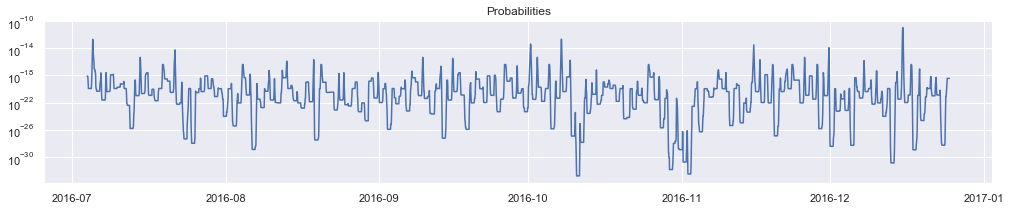

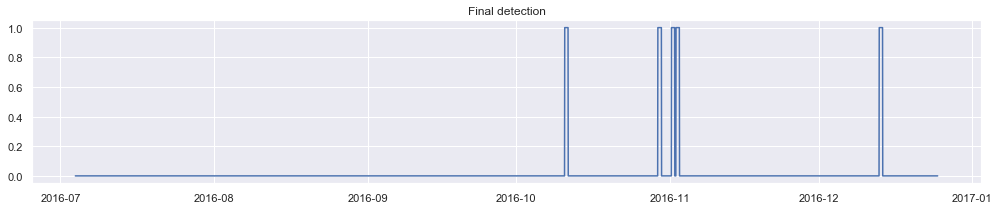

Signal L_T1 best configuration is n_bins 4, n 6, window 15, threshold 500 and F0.25 score 0.1937935402153262, precision 0.21176470588235294, recall 0.0821917808219178, TP 18, TN 3891, FP 67, FN 201
I am at signal L_T2


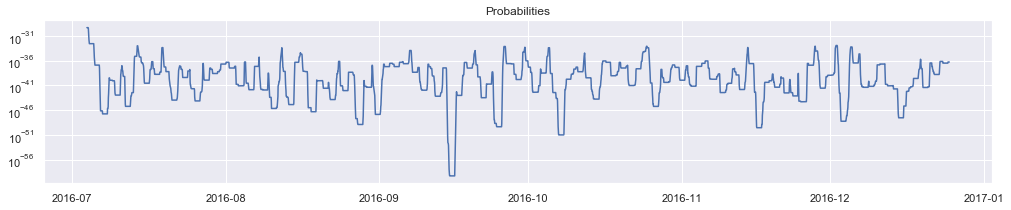

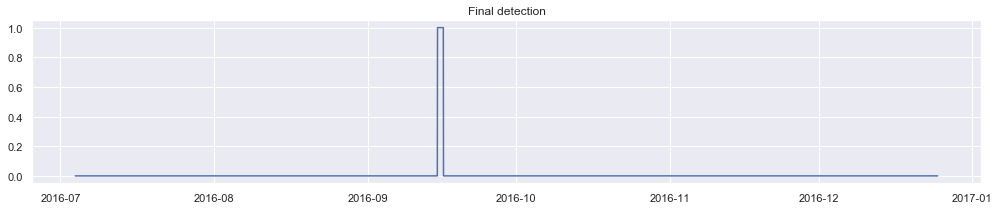

Signal L_T2 best configuration is n_bins 4, n 6, window 24, threshold 500 and F0.25 score 0.47291361639824303, precision 0.6551724137931034, recall 0.0867579908675799, TP 19, TN 3948, FP 10, FN 200
I am at signal L_T3


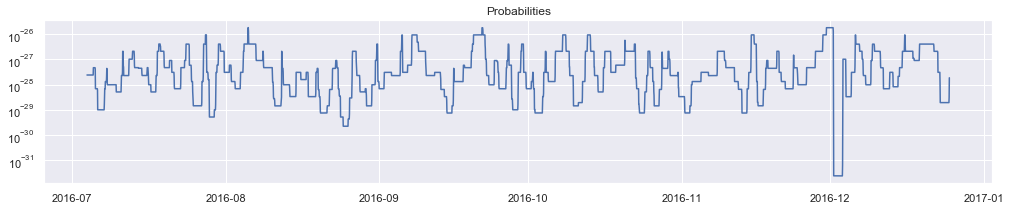

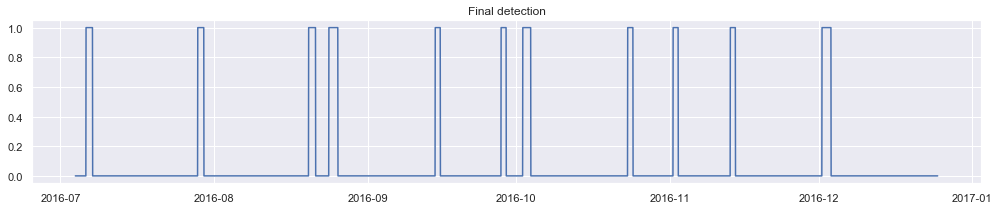

Signal L_T3 best configuration is n_bins 4, n 3, window 24, threshold 500 and F0.25 score 0.0732379803549888, precision 0.07163323782234957, recall 0.1141552511415525, TP 25, TN 3634, FP 324, FN 194
I am at signal F_PU1


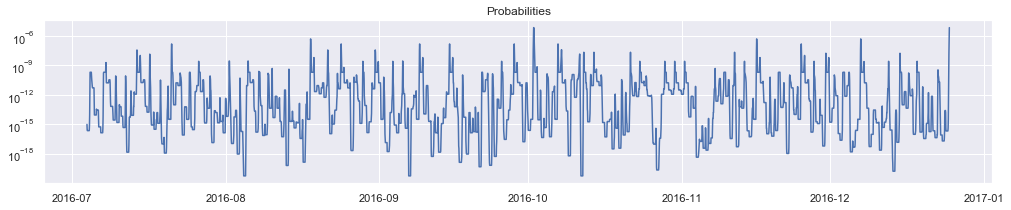

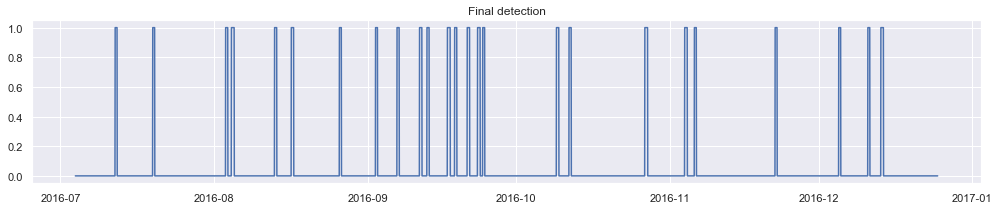

Signal F_PU1 best configuration is n_bins 4, n 6, window 10, threshold 500 and F0.25 score 0.03912952500523122, precision 0.03859649122807018, recall 0.0502283105022831, TP 11, TN 3684, FP 274, FN 208
I am at signal L_T4


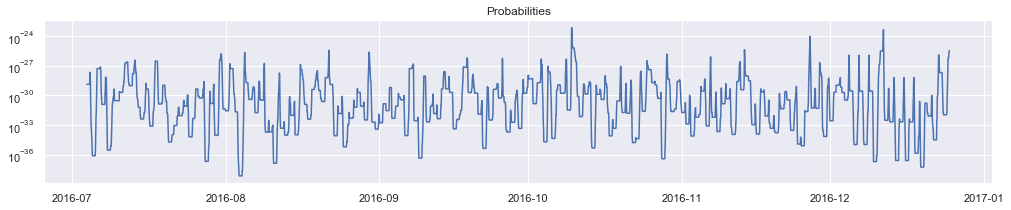

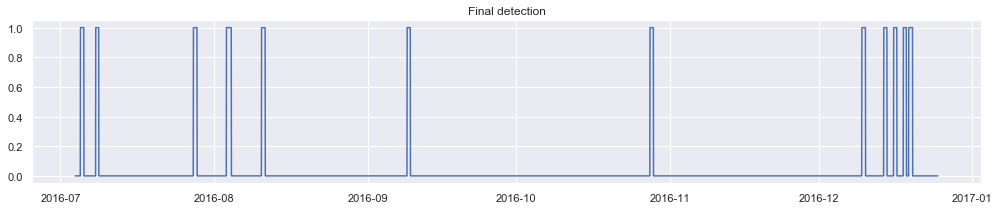

Signal L_T4 best configuration is n_bins 4, n 6, window 15, threshold 500 and F0.25 score 0.023856300870053325, precision 0.023923444976076555, recall 0.0228310502283105, TP 5, TN 3754, FP 204, FN 214
I am at signal F_PU10


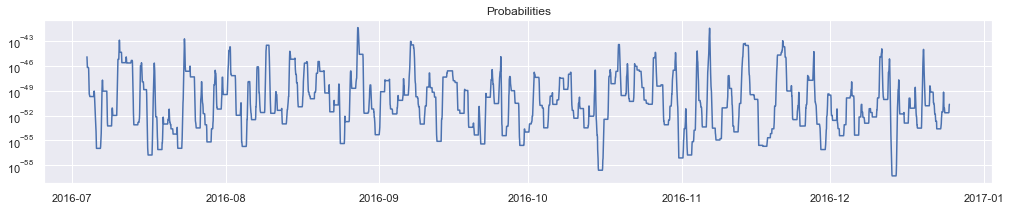

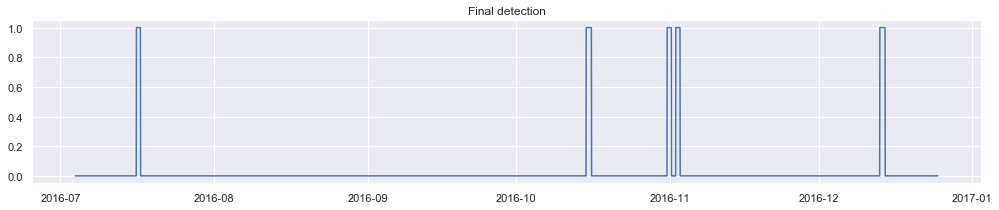

Signal F_PU10 best configuration is n_bins 4, n 6, window 20, threshold 500 and F0.25 score 0.17474302496328928, precision 0.18421052631578946, recall 0.0958904109589041, TP 21, TN 3865, FP 93, FN 198


In [30]:
grid_values = {}

#For each signal, discretize it and run Grid search
for signal in signal_names:
    print(f"I am at signal {signal}")
    params = grid_search_for_signal(data_train1[signal], data_train2[signal])
    grid_values[signal] = params
    
    print(f"Signal {signal} best configuration is n_bins {params[0]}, n {params[1]}, window {params[2]}, threshold {params[3]} and F0.25 score {params[4]}, precision {params[5]}, recall {params[6]}, TP {params[7]}, TN {params[8]}, FP {params[9]}, FN {params[10]}")
    




# Anomaly Types

Let's look at L_T1 first, since we have properly labeled attacks.

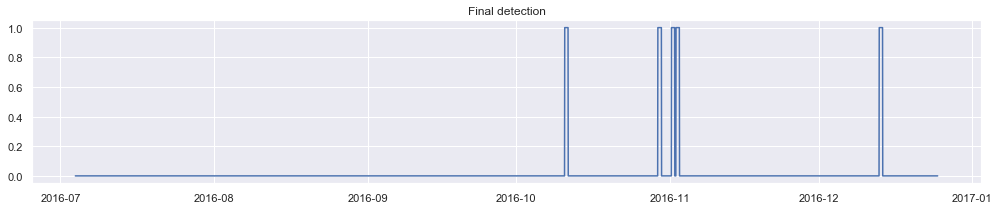

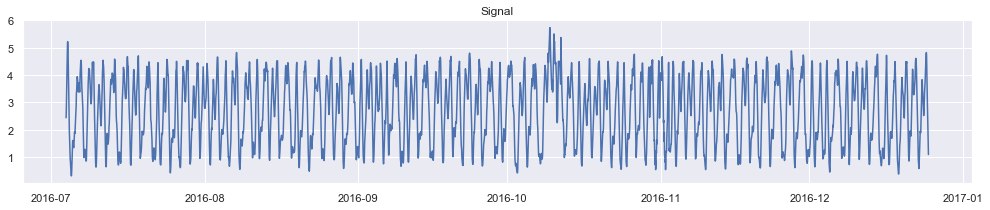

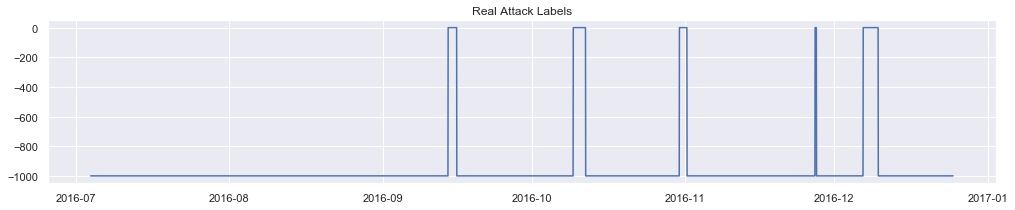

In [31]:
#choose signal for analysis
signal_name = 'L_T1'
signal = data_train1[signal_name]
signal2 = data_train2[signal_name]

#use the best parameter values obtained for grid search
n_bins = 4
n = 6
window = 15
threshold = 500

#discretize the signal
discrete_signal = discretize_signal(signal, n_bins)
discrete_signal2 = discretize_signal(signal2, n_bins)

#get the ngrams probabilities for this training data
ngrams_prob = ngram_probabilities(discrete_signal, n)

detection_series = pd.DataFrame(np.ones(discrete_signal2.size), discrete_signal2.index)

for num_idx, index in enumerate(discrete_signal2.index[:-window+1]):
    subset_series = discrete_signal2.iloc[num_idx:(num_idx+window)]

    subset_ngrams = get_ngrams(subset_series, n)
    prob_product = 1
    for ngram in subset_ngrams:
        if ngram in ngrams_prob.keys():
            prob_product *= ngrams_prob[ngram]
        else:
            prob_product *= ngrams_prob['other']

    for num_idx_det, index_det in enumerate(detection_series.index[num_idx:(num_idx+window)]):
        if detection_series.loc[index_det].item() > prob_product:
            detection_series.loc[index_det] = prob_product
            
            
min_prob = np.min(detection_series).item()

final_detection = pd.DataFrame(np.zeros(discrete_signal2.size), discrete_signal2.index)

thresh = threshold * min_prob

for num_idx_det, index_det in enumerate(detection_series.index):
    if detection_series.loc[index_det].item() < thresh:
        final_detection.loc[index_det] = 1
        
plt.figure(figsize=(17,3))
plt.plot(final_detection)
plt.title("Final detection")
plt.show()

plt.figure(figsize=(17,3))
plt.plot(signal2)
plt.title("Signal")
plt.show()

plt.figure(figsize=(17,3))
plt.plot(data_train2['ATT_FLAG'])
plt.title("Real Attack Labels")
plt.show()

Let's limit it in time when we have the attack for T1 and get a closer look at it.

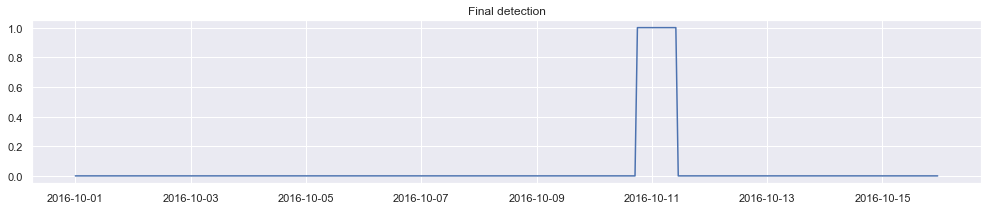

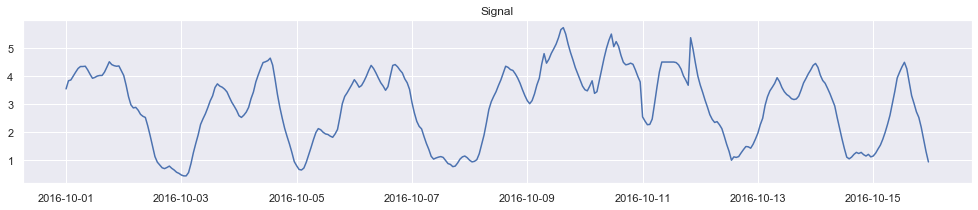

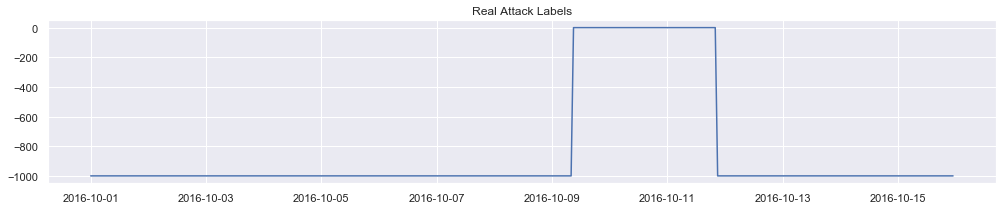

In [32]:
start_date = '2016-10-01'
end_date = '2016-10-15'


plt.figure(figsize=(17,3))
plt.plot(final_detection[start_date:end_date])
plt.title("Final detection")
plt.show()

plt.figure(figsize=(17,3))
plt.plot(signal2[start_date:end_date])
plt.title("Signal")
plt.show()

plt.figure(figsize=(17,3))
plt.plot(data_train2[start_date:end_date]['ATT_FLAG'])
plt.title("Real Attack Labels")
plt.show()
            

In the case of the 'L_T1' sensor this attack, according to the data documentation, results in overflow in T1. We can observe that the detection method manages to detect the anomaly, which is a collection of multiple **point anomalies**. 

Let's look at L_T4, since it also has labeled attacks.

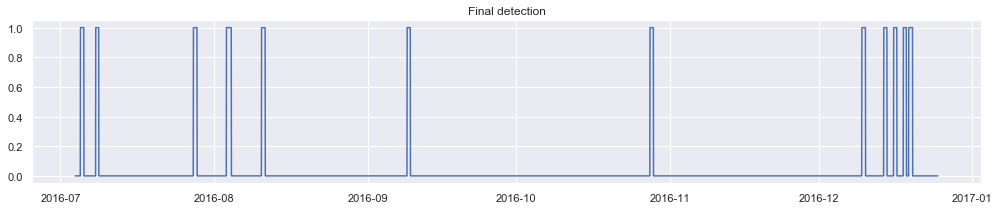

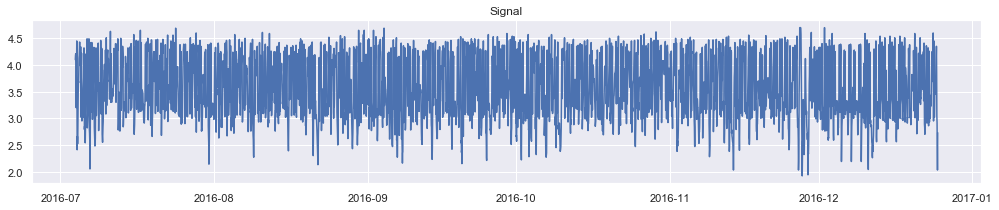

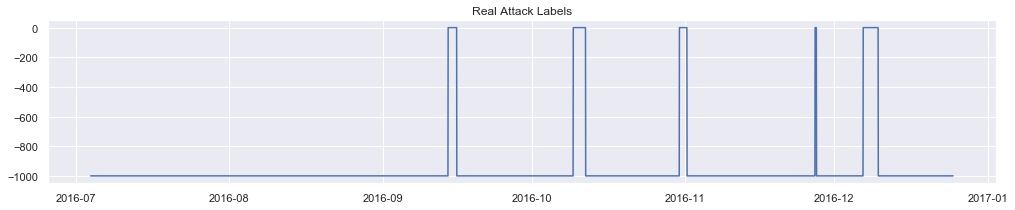

In [33]:
#choose signal for analysis
signal_name = 'L_T4'
signal = data_train1[signal_name]
signal2 = data_train2[signal_name]

#use the best parameter values obtained for grid search
n_bins = 4
n = 6
window = 15
threshold = 500

#discretize the signal
discrete_signal = discretize_signal(signal, n_bins)
discrete_signal2 = discretize_signal(signal2, n_bins)

#get the ngrams probabilities for this training data
ngrams_prob = ngram_probabilities(discrete_signal, n)

detection_series = pd.DataFrame(np.ones(discrete_signal2.size), discrete_signal2.index)

for num_idx, index in enumerate(discrete_signal2.index[:-window+1]):
    subset_series = discrete_signal2.iloc[num_idx:(num_idx+window)]

    subset_ngrams = get_ngrams(subset_series, n)
    prob_product = 1
    for ngram in subset_ngrams:
        if ngram in ngrams_prob.keys():
            prob_product *= ngrams_prob[ngram]
        else:
            prob_product *= ngrams_prob['other']

    for num_idx_det, index_det in enumerate(detection_series.index[num_idx:(num_idx+window)]):
        if detection_series.loc[index_det].item() > prob_product:
            detection_series.loc[index_det] = prob_product
            
            
min_prob = np.min(detection_series).item()

final_detection = pd.DataFrame(np.zeros(discrete_signal2.size), discrete_signal2.index)

thresh = threshold * min_prob

for num_idx_det, index_det in enumerate(detection_series.index):
    if detection_series.loc[index_det].item() < thresh:
        final_detection.loc[index_det] = 1
        
plt.figure(figsize=(17,3))
plt.plot(final_detection)
plt.title("Final detection")
plt.show()

plt.figure(figsize=(17,3))
plt.plot(signal2)
plt.title("Signal")
plt.show()

plt.figure(figsize=(17,3))
plt.plot(data_train2['ATT_FLAG'])
plt.title("Real Attack Labels")
plt.show()

We can see that we manage detect a bit of the attack in the beginning of December 2016. Let's have a closer look at it.

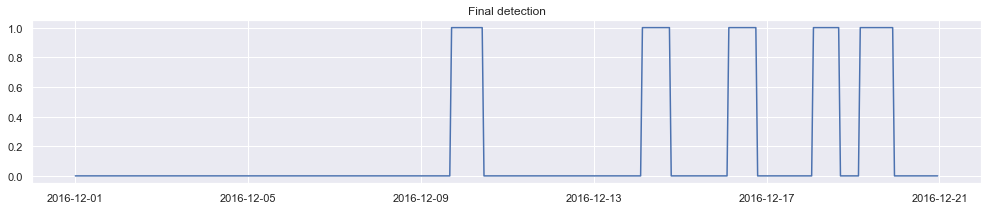

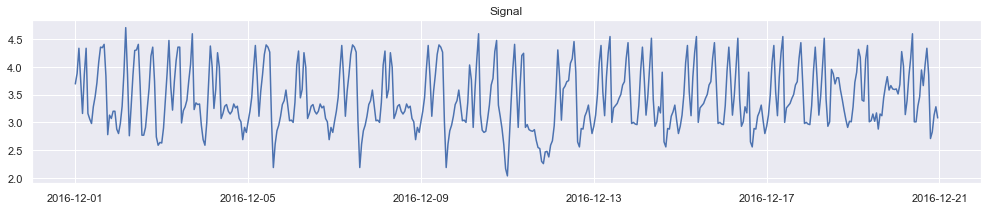

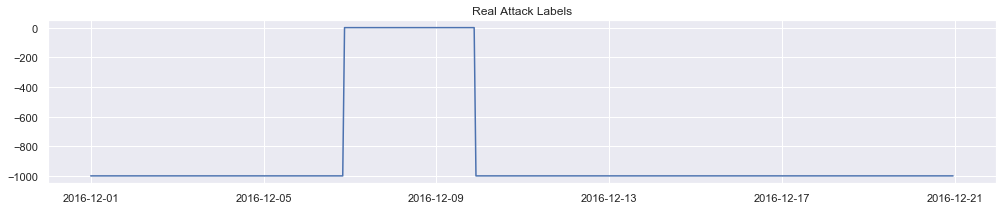

In [35]:
start_date = '2016-12-01'
end_date = '2016-12-20'


plt.figure(figsize=(17,3))
plt.plot(final_detection[start_date:end_date])
plt.title("Final detection")
plt.show()

plt.figure(figsize=(17,3))
plt.plot(signal2[start_date:end_date])
plt.title("Signal")
plt.show()

plt.figure(figsize=(17,3))
plt.plot(data_train2[start_date:end_date]['ATT_FLAG'])
plt.title("Real Attack Labels")
plt.show()

Also in this case, using the n-grams approach, we can detect multiple **point anomalies** for the labeled attack starting on 6th December 2016. 

Also, very nice to note is that the attack taking place between 14th and 19th December 2016, which also affects T4, is partially detected, although it is not labeled at all in the dataset. This attack also corresponds to multiple **point anomalies**, more specifically several points where the water level in T4 are lower than usual.

# Run on test set

Let's take the best configuration for each of the signals and run it on the test set.

Let's first create a dictionary with the best values obtained from the grid search for each of the signals we have analyzed.

In [36]:
best_parameters = {'L_T1': {'n_bins':4, 'n':6, 'window':15 , 'threshold':500},
                  'L_T2': {'n_bins':4, 'n':6, 'window':24, 'threshold':500},
                  'L_T3': {'n_bins':4, 'n':3, 'window':24, 'threshold':500},
                   'L_T4': {'n_bins':4, 'n':6, 'window':15, 'threshold':500},
                   'F_PU1': {'n_bins':4, 'n':6, 'window':10, 'threshold':500},
                   'F_PU10': {'n_bins':4, 'n':6, 'window':20, 'threshold':500}
                  }

By looking at the BATADAL documentation provided on the website we can observe that we have recorded attacks for the water level in towers 2 and 3. Let's have a look at the associated variables, 'L_T2' and 'L_T3' and check if we can detect any attacks.

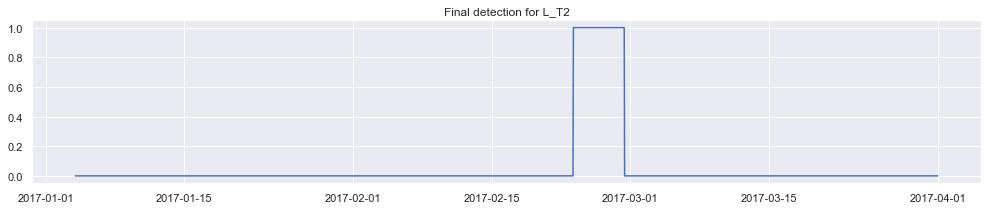

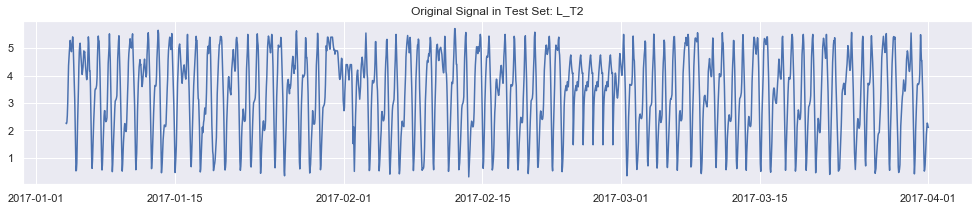

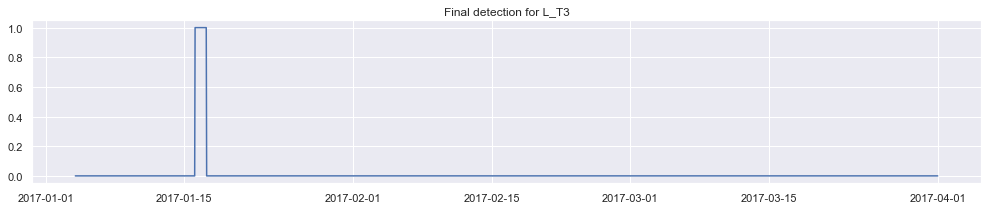

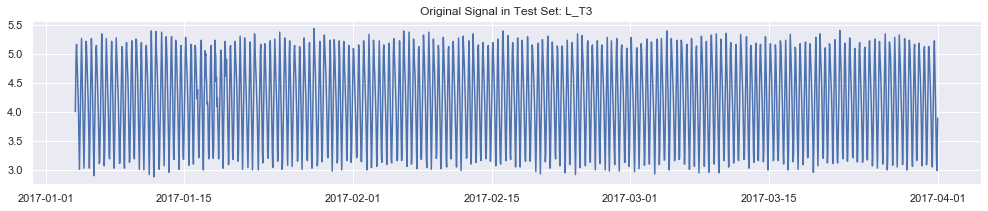

In [38]:
#read data
file_name_test = "test_set"

DATA_PATH_TEST = r"C:../data/{}.csv".format(file_name_test)

data_test = pd.read_csv(DATA_PATH_TEST, parse_dates=['DATETIME'], index_col = ['DATETIME'], dayfirst=True)

signal_names_test = ['L_T2', 'L_T3']

for signal_name in signal_names_test:
    signal = data_train1[signal_name]
    signal_test = data_test[signal_name]

    #use the best parameter values obtained for grid search
    n_bins = best_parameters[signal_name]['n_bins']
    n = best_parameters[signal_name]['n']
    window = best_parameters[signal_name]['window']
    threshold = best_parameters[signal_name]['threshold']

    #discretize the signal
    discrete_signal = discretize_signal(signal, n_bins)
    discrete_signal_test= discretize_signal(signal_test, n_bins)

    #get the ngrams probabilities for this training data
    ngrams_prob = ngram_probabilities(discrete_signal, n)

    detection_series = pd.DataFrame(np.ones(discrete_signal_test.size), discrete_signal_test.index)

    for num_idx, index in enumerate(discrete_signal_test.index[:-window+1]):
        subset_series = discrete_signal_test.iloc[num_idx:(num_idx+window)]

        subset_ngrams = get_ngrams(subset_series, n)
        prob_product = 1
        for ngram in subset_ngrams:
            if ngram in ngrams_prob.keys():
                prob_product *= ngrams_prob[ngram]
            else:
                prob_product *= ngrams_prob['other']

        for num_idx_det, index_det in enumerate(detection_series.index[num_idx:(num_idx+window)]):
            if detection_series.loc[index_det].item() > prob_product:
                detection_series.loc[index_det] = prob_product
            
            
    min_prob = np.min(detection_series).item()

    final_detection = pd.DataFrame(np.zeros(discrete_signal_test.size), discrete_signal_test.index)

    thresh = threshold * min_prob

    for num_idx_det, index_det in enumerate(detection_series.index):
        if detection_series.loc[index_det].item() < thresh:
            final_detection.loc[index_det] = 1

    plt.figure(figsize=(17,3))
    plt.plot(final_detection)
    plt.title(f"Final detection for {signal_name}")
    plt.show()

    plt.figure(figsize=(17,3))
    plt.plot(signal_test)
    plt.title(f"Original Signal in Test Set: {signal_name}")
    plt.show()

Unfortunately, none of the two attacks affecting towers 2 and 3 were identified for the test set. It can be the case that a better labeling of the attacks in the training sets could help improve the performance on the test set.